In [12]:
%%time
import sys
!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install -r requirements.txt


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 43.8 ms, sys: 20.1 ms, total: 63.9 ms
Wall time: 2.09 s


In [13]:
%%time
import numpy as np
import matplotlib.pyplot as plt   

from xgboost import XGBClassifier
from matplotlib import pyplot
from matplotlib.pyplot import figure
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import * 


CPU times: user 268 µs, sys: 2 µs, total: 270 µs
Wall time: 278 µs


In [14]:
%%time
import pandas as pd
dataset =  np.loadtxt('numerical_only_all.csv', delimiter=',')

CPU times: user 1min 15s, sys: 845 ms, total: 1min 16s
Wall time: 1min 16s


In [15]:
%%time
fields =['isFraud','step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
         'newbalanceDest', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
df = pd.DataFrame(data=dataset, columns=fields)
print('Length', len(dataset))

Length 6362620
CPU times: user 1.41 ms, sys: 13 µs, total: 1.43 ms
Wall time: 1.28 ms


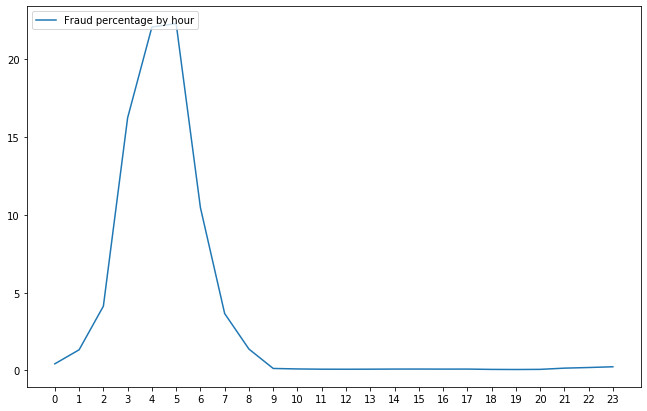

In [16]:
HOURS_IN_DAY  =24
df['hour'] = df['step'] % HOURS_IN_DAY
frauds_by_hour = []
non_frauds_by_hour = []
hourwise_items = []
for hour in range(HOURS_IN_DAY):
    non_fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 0)]
    non_fraud_sum_in_hour = len(non_fraud_in_hour)
    fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 1)]
    fraud_sum_in_hour = len(fraud_in_hour)
    non_frauds_by_hour.append(non_fraud_sum_in_hour)
    frauds_by_hour.append(fraud_sum_in_hour)
    hourwise_items.append(non_fraud_sum_in_hour+fraud_sum_in_hour)

fig, ax = plt.subplots(figsize=(11, 7))
 
fr_non_fraud = ax.plot(np.multiply(np.divide(frauds_by_hour,hourwise_items), 100), label='Fraud percentage by hour')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper left' )
 
conditions = [(df['hour'] >=2) & (df['hour'] <=6)]

 
series = pd.Series(np.select(conditions, [1], 0))
df['peakHours']=series

del df['hour']
del df['step']
 

In [17]:
X = dataset[:,1:]
y = dataset[:,0]

In [18]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [19]:
%%time
import datetime
print(f'Start fit at {str(datetime.datetime.now())[:-7]}Z')
model = XGBClassifier()
model.fit(X, y)

Start fit at 2020-12-01 10:27:00Z
[10:27:05] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 43min 25s, sys: 13.9 s, total: 43min 39s
Wall time: 11min 10s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

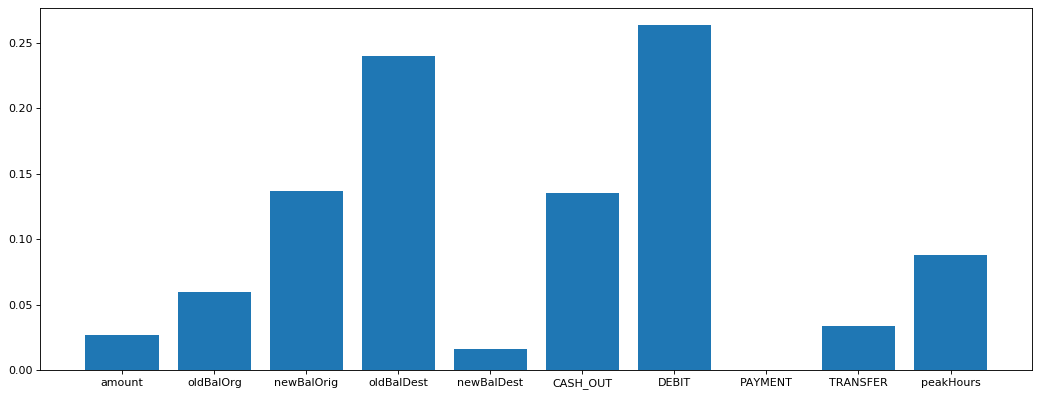

CPU times: user 530 ms, sys: 7.98 ms, total: 538 ms
Wall time: 384 ms


In [20]:
%%time

fields_short_names = [s.replace('balance', 'Bal') for s in df.columns[1:]]
 
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_short_names)
        
pyplot.show()

accuracy_score: 99.98%
f1_score: 93.56%
precision_score: 98.31%
recall_score: 89.26%
balanced_accuracy_score: 94.63%


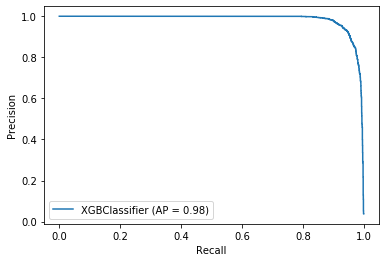

In [21]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Not auc, roc_auc_score
functions = [accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score ]
for f in functions:
  print("%s: %.2f%%" % (f.__name__, f(y_test, predictions) * 100.0))
plot_precision_recall_curve(model, X_test, y_test)  